# COF Workbook

In this workbook we try to predict the methane uptake from a subset of chemical and topological features of a Covalent Organic Framework (COF):

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error as mse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas

## Get Dataset
Lets get some data to work with from https://pubs.acs.org/doi/10.1021/acs.chemmater.8b01425

In [2]:
data = pandas.read_csv('properties/properties.csv')
data.head(100)

,dimensions,bond type,name,void fraction [widom],supercell volume [A^3],density [kg/m^3],heat desorption high P [kJ/mol],heat desorption error high P [kJ/mol],absolute methane uptake high P [molec/unit cell],absolute methane uptake error high P [molec/unit cell],...,num sulfur,num silicon,vertices,edges,genus,largest included sphere diameter [A],largest free sphere diameter [A],largest included sphere along free sphere path diameter [A],absolute methane uptake high P [v STP/v],absolute methane uptake low P [v STP/v]
0,2,amide,linker91_CO_linker87_NH_hcb_relaxed,0.900120,49204.128057,260.213228,10.95162,0.315667,233.2892,2.789059,...,0,0,1,1,0,17.19014,15.64961,17.19004,176.160498,20.988007
1,2,amide,linker91_CO_linker88_NH_hcb_relaxed,0.879234,49390.074419,297.963387,11.81756,0.478028,250.6164,3.464625,...,0,0,1,1,0,17.34916,15.76943,17.34916,188.532073,22.643282
2,2,amide,linker91_CO_linker7_NH_hcb_relaxed,0.858269,50036.985281,289.397249,11.86378,0.140491,255.1510,0.921036,...,0,0,1,1,0,16.84032,15.61907,16.84024,189.461764,22.566022
3,2,amide,linker91_CO_linker8_NH_hcb_relaxed,0.857065,49135.924517,370.063633,12.48842,0.823728,257.3368,2.377728,...,0,0,1,1,0,13.93085,12.32167,13.93085,194.588962,27.373459
4,2,amide,linker91_CO_linker10_NH_hcb_relaxed,0.858016,49540.680132,367.040151,12.25924,0.191371,253.2620,3.177484,...,0,0,1,1,0,16.06923,13.48791,16.06921,189.943092,24.774006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,amide,linker92_CO_linker25_NH_hcb_relaxed,0.883475,22587.266828,250.298742,10.00872,0.112226,90.2396,2.241298,...,0,0,1,1,0,23.68603,21.83253,23.68602,148.439306,18.108886
96,2,amide,linker92_CO_linker2_NH_hcb_relaxed,0.890733,50147.566332,272.034501,11.42811,0.365713,250.3400,3.012522,...,0,0,1,1,0,17.10292,15.68184,17.10292,185.479460,22.779136
97,2,amide,linker92_CO_linker28_NH_hcb_relaxed,0.899825,22771.019307,218.746587,9.96747,0.280106,92.3006,1.618102,...,0,0,1,1,0,24.72916,23.58912,24.72916,150.604341,17.684718
98,2,amide,linker92_CO_linker30_NH_hcb_relaxed,0.919643,22896.478485,189.467295,9.69329,0.356563,90.8544,0.807983,...,0,0,1,1,0,26.38766,25.10693,26.38766,147.432323,15.400374


Let's inspect the columns to understand what data we are dealing with:

In [3]:
data.columns

Index(['dimensions', ' bond type', ' name', ' void fraction [widom]',
       ' supercell volume [A^3]', ' density [kg/m^3]',
       ' heat desorption high P [kJ/mol]',
       ' heat desorption error high P [kJ/mol]',
       ' absolute methane uptake high P [molec/unit cell]',
       ' absolute methane uptake error high P [molec/unit cell]',
       ' absolute methane uptake high P [mol/kg]',
       ' absolute methane uptake error high P [mol/kg]',
       ' excess methane uptake high P [molec/unit cell]',
       ' excess methane uptake error high P [molec/unit cell]',
       ' excess methane uptake high P [mol/kg]',
       ' excess methane uptake error high P [mol/kg]',
       ' heat desorption low P [kJ/mol]',
       ' heat desorption error low P [kJ/mol]',
       ' absolute methane uptake low P [molec/unit cell]',
       ' absolute methane uptake error low P [molec/unit cell]',
       ' absolute methane uptake low P [mol/kg]',
       ' absolute methane uptake error low P [mol/kg]',
   

## Dataset post-processing

Lets extract the columns we will need to fit the data. We choose these as intuitively they are most likely to impact the COF's ability to absorb methane.


In [4]:
columns=[' name', 
         ' void fraction [widom]', 
         ' num carbon',
         ' num fluorine',
         ' num hydrogen',
         ' num nitrogen',
         ' num oxygen',
        ' num sulfur',
        ' num silicon', 
        ' vertices', 
        ' edges', 
        ' genus',
        ' largest included sphere diameter [A]',
        ' net',
        ' absolute methane uptake low P [molec/unit cell]']
filtered_df = data[columns]
filtered_df.head(10)


,name,void fraction [widom],num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,vertices,edges,genus,largest included sphere diameter [A],net,absolute methane uptake low P [molec/unit cell]
0,linker91_CO_linker87_NH_hcb_relaxed,0.900120,360,0,216,144,72,0,0,1,1,0,17.19014,hcb,27.7944
1,linker91_CO_linker88_NH_hcb_relaxed,0.879234,360,0,216,144,144,0,0,1,1,0,17.34916,hcb,30.0998
2,linker91_CO_linker7_NH_hcb_relaxed,0.858269,432,0,360,144,72,0,0,1,1,0,16.84032,hcb,30.3900
3,linker91_CO_linker8_NH_hcb_relaxed,0.857065,360,0,144,216,216,0,0,1,1,0,13.93085,hcb,36.2004
4,linker91_CO_linker10_NH_hcb_relaxed,0.858016,360,0,144,216,216,0,0,1,1,0,16.06923,hcb,33.0326
5,linker91_CO_linker11_NH_hcb_relaxed,0.844621,360,0,360,288,72,0,0,1,1,0,16.50191,hcb,30.9732
6,linker91_CO_linker12_NH_hcb_relaxed,0.867641,360,0,216,144,216,0,0,1,1,0,15.66491,hcb,35.5468
7,linker91_CO_linker14_NH_hcb_relaxed,0.877187,162,0,126,36,36,0,0,1,1,0,20.73294,hcb,10.8636
8,linker91_CO_linker16_NH_hcb_relaxed,0.895879,144,0,108,54,18,0,0,1,1,0,22.21728,hcb,9.8744
9,linker91_CO_linker17_NH_hcb_relaxed,0.869602,144,0,90,72,54,0,0,1,1,0,22.06483,hcb,11.7466


In [5]:
#Find range of absolute methane uptake. We will need this later for some of the plots.
filtered_df[[' absolute methane uptake low P [molec/unit cell]']].describe()

,absolute methane uptake low P [molec/unit cell]
count,69840.000000
mean,47.453022
std,33.269524
min,0.651200
25%,23.802950
50%,38.137700
75%,61.560200
max,456.339400


Text(0, 0.5, 'Count')

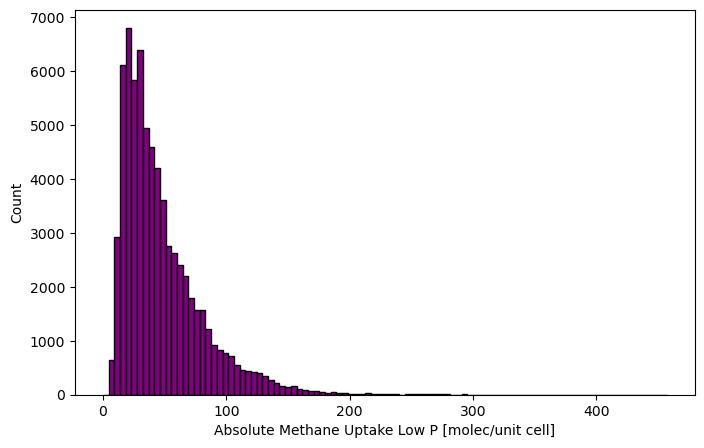

In [6]:
# Lets take a look at the distribution of absolute methane uptake
fig, ax = plt.subplots(figsize=[8, 5], dpi=100)
ax.hist(filtered_df[' absolute methane uptake low P [molec/unit cell]'], color='purple', edgecolor='k', bins=np.linspace(0, 457, 100))
ax.set_xlabel('Absolute Methane Uptake Low P [molec/unit cell]')
ax.set_ylabel('Count')

## Interlude
Let's also just investigate if the High and Low Methane Uptake variables are correlated, and if therefore we are entitled to choose Absolute Methane Uptake Low P [molec/unit cell] to represent them all:

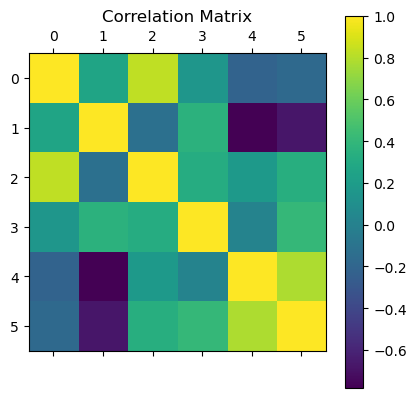

In [7]:
methane_cols = [' absolute methane uptake high P [molec/unit cell]',
       ' absolute methane uptake high P [mol/kg]',
       ' absolute methane uptake low P [molec/unit cell]',
       ' absolute methane uptake low P [mol/kg]',
       ' absolute methane uptake high P [v STP/v]',
       ' absolute methane uptake low P [v STP/v]']

df_methane = data[methane_cols]
plt.matshow(df_methane.corr())
cb = plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

Interestingly the High and Low P Absolute Methane Uptake features do not appear to be correlated. This means the results for High P could be different, and therefore for future work we could investigate this as a separate case.

## Featurise Dataset

In [8]:
# We wish to create a new column from the name that contains the hba, etc information. Before realizing this information already existed
# in the net column, we created a function that would split the name and extract the information that way. We include it just for thoroughness.
# def split_name(name):
#      name_split=(name.split("_"))
#      return name_split[-2]
# suffix = filtered_df[' name'].apply(split_name)
# filtered_df.insert(1, 'suffix', suffix)
# filtered_df = pd.get_dummies(filtered_df, columns=['suffix'])

# We do one hot-encoding on the net column:
filtered_df = pd.get_dummies(filtered_df, columns=[' net'])
filtered_df.head(10)


,name,void fraction [widom],num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,vertices,...,net_ wix,net_ wjh,net_ wse,net_ xaa,net_ xad,net_ xai,net_ xci,net_ xux,net_ zme,net_ zni
0,linker91_CO_linker87_NH_hcb_relaxed,0.900120,360,0,216,144,72,0,0,1,...,False,False,False,False,False,False,False,False,False,False
1,linker91_CO_linker88_NH_hcb_relaxed,0.879234,360,0,216,144,144,0,0,1,...,False,False,False,False,False,False,False,False,False,False
2,linker91_CO_linker7_NH_hcb_relaxed,0.858269,432,0,360,144,72,0,0,1,...,False,False,False,False,False,False,False,False,False,False
3,linker91_CO_linker8_NH_hcb_relaxed,0.857065,360,0,144,216,216,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,linker91_CO_linker10_NH_hcb_relaxed,0.858016,360,0,144,216,216,0,0,1,...,False,False,False,False,False,False,False,False,False,False
5,linker91_CO_linker11_NH_hcb_relaxed,0.844621,360,0,360,288,72,0,0,1,...,False,False,False,False,False,False,False,False,False,False
6,linker91_CO_linker12_NH_hcb_relaxed,0.867641,360,0,216,144,216,0,0,1,...,False,False,False,False,False,False,False,False,False,False
7,linker91_CO_linker14_NH_hcb_relaxed,0.877187,162,0,126,36,36,0,0,1,...,False,False,False,False,False,False,False,False,False,False
8,linker91_CO_linker16_NH_hcb_relaxed,0.895879,144,0,108,54,18,0,0,1,...,False,False,False,False,False,False,False,False,False,False
9,linker91_CO_linker17_NH_hcb_relaxed,0.869602,144,0,90,72,54,0,0,1,...,False,False,False,False,False,False,False,False,False,False


In [9]:
#Move the column we will be predicting to the end of the dataframe just for ease.
column_to_move = filtered_df.pop(' absolute methane uptake low P [molec/unit cell]')
filtered_df.insert(len(filtered_df.columns), ' absolute methane uptake low P [molec/unit cell]', column_to_move)
filtered_df.head(10)

,name,void fraction [widom],num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,vertices,...,net_ wjh,net_ wse,net_ xaa,net_ xad,net_ xai,net_ xci,net_ xux,net_ zme,net_ zni,absolute methane uptake low P [molec/unit cell]
0,linker91_CO_linker87_NH_hcb_relaxed,0.900120,360,0,216,144,72,0,0,1,...,False,False,False,False,False,False,False,False,False,27.7944
1,linker91_CO_linker88_NH_hcb_relaxed,0.879234,360,0,216,144,144,0,0,1,...,False,False,False,False,False,False,False,False,False,30.0998
2,linker91_CO_linker7_NH_hcb_relaxed,0.858269,432,0,360,144,72,0,0,1,...,False,False,False,False,False,False,False,False,False,30.3900
3,linker91_CO_linker8_NH_hcb_relaxed,0.857065,360,0,144,216,216,0,0,1,...,False,False,False,False,False,False,False,False,False,36.2004
4,linker91_CO_linker10_NH_hcb_relaxed,0.858016,360,0,144,216,216,0,0,1,...,False,False,False,False,False,False,False,False,False,33.0326
5,linker91_CO_linker11_NH_hcb_relaxed,0.844621,360,0,360,288,72,0,0,1,...,False,False,False,False,False,False,False,False,False,30.9732
6,linker91_CO_linker12_NH_hcb_relaxed,0.867641,360,0,216,144,216,0,0,1,...,False,False,False,False,False,False,False,False,False,35.5468
7,linker91_CO_linker14_NH_hcb_relaxed,0.877187,162,0,126,36,36,0,0,1,...,False,False,False,False,False,False,False,False,False,10.8636
8,linker91_CO_linker16_NH_hcb_relaxed,0.895879,144,0,108,54,18,0,0,1,...,False,False,False,False,False,False,False,False,False,9.8744
9,linker91_CO_linker17_NH_hcb_relaxed,0.869602,144,0,90,72,54,0,0,1,...,False,False,False,False,False,False,False,False,False,11.7466


In [10]:
# Drop columns (descriptors) with nan values
X_desc = filtered_df.dropna(how='any',axis=1)
# Ensure dtype is float32
X_desc_nameless= X_desc.iloc[: , 1:]
float64_cols = list(X_desc_nameless.select_dtypes(include='float64'))
X_desc_nameless[float64_cols] = X_desc_nameless[float64_cols].astype('float32')
X_desc_nameless.replace([np.inf, -np.inf], np.nan, inplace=True)
X_desc_nameless.dropna(how='any',axis=1, inplace=True)
print(X_desc_nameless.shape)
X_desc_nameless.head(5)

(69840, 354)


c:\Users\judge\anaconda3\envs\digichem_2024\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


,num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,vertices,edges,genus,...,net_ wjh,net_ wse,net_ xaa,net_ xad,net_ xai,net_ xci,net_ xux,net_ zme,net_ zni,absolute methane uptake low P [molec/unit cell]
0,360,0,216,144,72,0,0,1,1,0,...,False,False,False,False,False,False,False,False,False,27.794399
1,360,0,216,144,144,0,0,1,1,0,...,False,False,False,False,False,False,False,False,False,30.099800
2,432,0,360,144,72,0,0,1,1,0,...,False,False,False,False,False,False,False,False,False,30.389999
3,360,0,144,216,216,0,0,1,1,0,...,False,False,False,False,False,False,False,False,False,36.200401
4,360,0,144,216,216,0,0,1,1,0,...,False,False,False,False,False,False,False,False,False,33.032600


## Test/Train Split for Model

In [11]:
# Preparing train test split
X = X_desc_nameless.iloc[:, :-1]
y = X_desc_nameless[' absolute methane uptake low P [molec/unit cell]']

# Generate train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [12]:
y

0         27.794399
1         30.099800
2         30.389999
3         36.200401
4         33.032600
            ...    
69835     60.131401
69836     79.632004
69837     78.848999
69838    188.736404
69839     50.067902
Name:  absolute methane uptake low P [molec/unit cell], Length: 69840, dtype: float32

## Hyperparameter Tuning
We use a randomised search method to find the best parameters for the random-forest model. We only do 7 iterations and 2-CV due to limited computing power, but ideally would do more. 

In [13]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 500, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_tuning = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_tuning, 
                               param_distributions = random_grid, 
                               n_iter = 7, 
                               cv = 2, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 2 folds for each of 7 candidates, totalling 14 fits


{'n_estimators': 396,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 255}

## Train/Validate Optimal Model

In [14]:
#Look at test results for test and train data.
tr_preds = rf_random.best_estimator_.predict(X_train)
te_preds = rf_random.best_estimator_.predict(X_test)

## Results

Train MSE: 10.041
Test MSE: 32.228
Test RMSE: 5.677
Test MAE: 2.699
Test R-Squared: 0.970


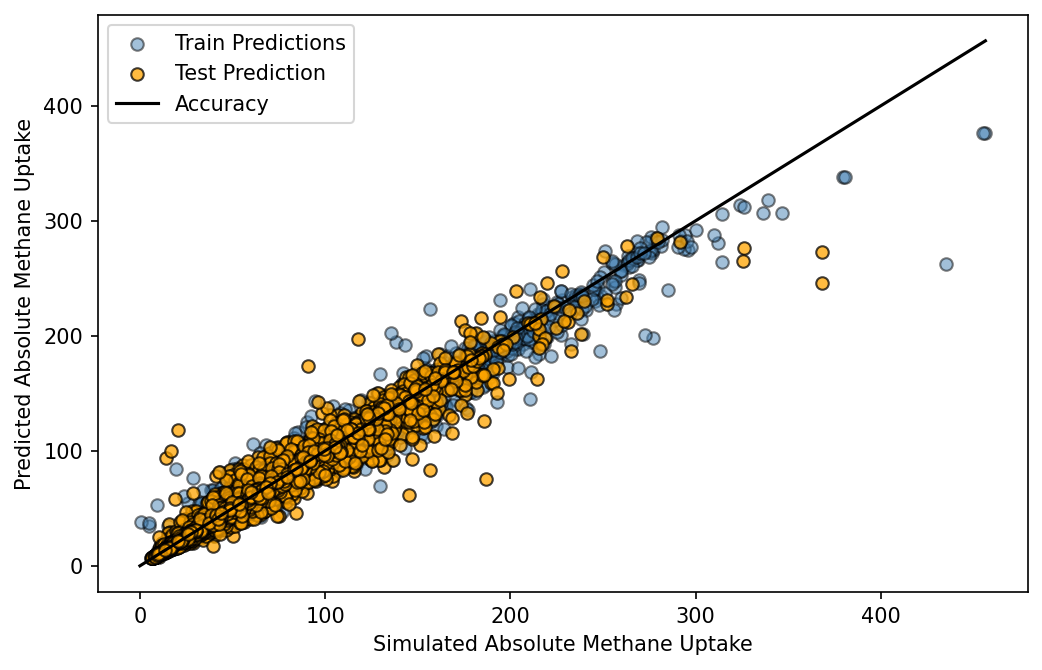

In [15]:
fig, ax = plt.subplots(figsize=[8, 5], dpi=150)
acc = np.linspace(0, np.max(np.concatenate([y_train, tr_preds, y_test, te_preds])), 1000)
ax.scatter(y_train, tr_preds, color='steelblue', edgecolor='k', alpha=0.5, label='Train Predictions')
ax.scatter(y_test, te_preds, color='orange', edgecolor='k', alpha=0.75, label='Test Prediction')
ax.plot(acc, acc, label='Accuracy', color='black')
ax.set_xlabel('Simulated Absolute Methane Uptake')
ax.set_ylabel('Predicted Absolute Methane Uptake')
plt.legend()
print(f'Train MSE: {mse(y_train, tr_preds):.3f}')
print(f'Test MSE: {mse(y_test, te_preds):.3f}')
print(f'Test RMSE: {mse(y_test, te_preds, squared=False):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, te_preds):.3f}')
print(f'Test R-Squared: {r2_score(y_test, te_preds):.3f}')

Text(0.5, 1.0, 'Global Feature Importance for Methane Uptake')

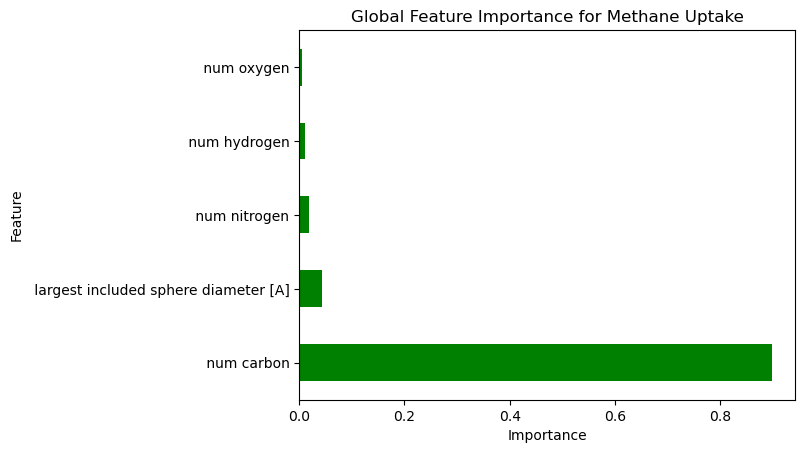

In [17]:
global_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=False, inplace=True)
global_importances.head(5).plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance for Methane Uptake")

From the above, it looks as if the number of carbon atoms is the most significant feature by far. Let's test this by just using the number of carbons to build our model on:

Train MSE: 116.103
Test MSE: 115.456
Test RMSE: 10.745
Test MAE: 6.436
Test R-Squared: 0.894


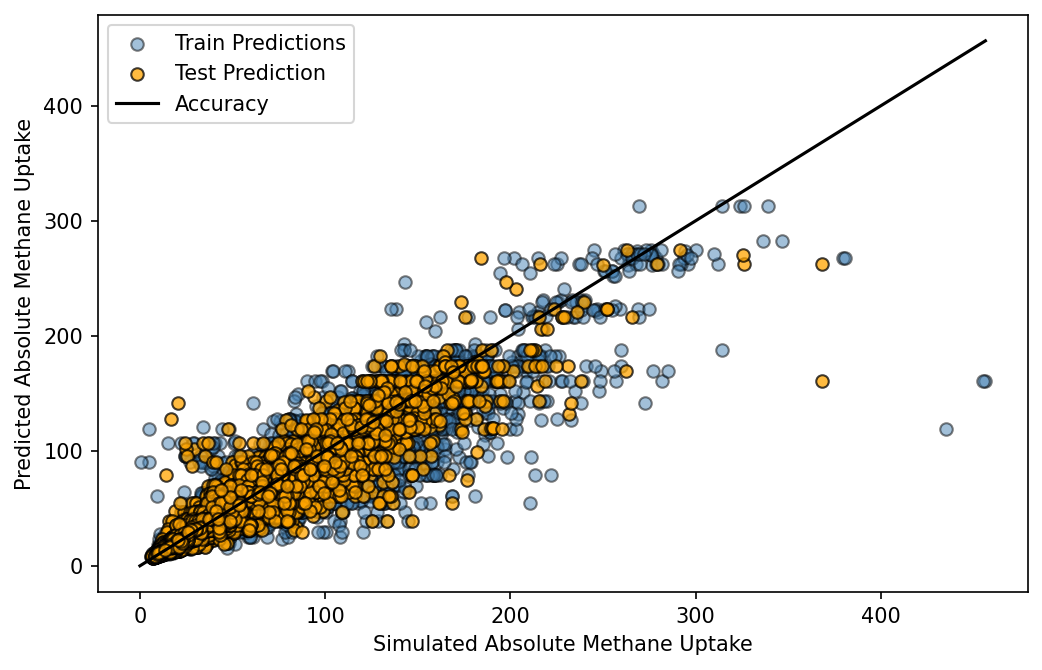

In [18]:
#Predict just using the number of carbons:
rf_carbon = RandomForestRegressor(n_estimators=396, min_samples_split=2, min_samples_leaf=2, max_depth=255, bootstrap=True, random_state=128)
# Preparing train test split
X = X_desc_nameless[[' num carbon']]
y = X_desc_nameless[' absolute methane uptake low P [molec/unit cell]']

# Generate train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
rf_carbon.fit(X_train, y_train)
tr_preds = rf_carbon.predict(X_train)
te_preds = rf_carbon.predict(X_test)

fig, ax = plt.subplots(figsize=[8, 5], dpi=150)
acc = np.linspace(0, np.max(np.concatenate([y_train, tr_preds, y_test, te_preds])), 1000)
ax.scatter(y_train, tr_preds, color='steelblue', edgecolor='k', alpha=0.5, label='Train Predictions')
ax.scatter(y_test, te_preds, color='orange', edgecolor='k', alpha=0.75, label='Test Prediction')
ax.plot(acc, acc, label='Accuracy', color='black')
ax.set_xlabel('Simulated Absolute Methane Uptake')
ax.set_ylabel('Predicted Absolute Methane Uptake')
plt.legend()
print(f'Train MSE: {mse(y_train, tr_preds):.3f}')
print(f'Test MSE: {mse(y_test, te_preds):.3f}')
print(f'Test RMSE: {mse(y_test, te_preds, squared=False):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, te_preds):.3f}')
print(f'Test R-Squared: {r2_score(y_test, te_preds):.3f}')

## What's Next?
Look into Crystal Graph Neural Network. Also, could use dimensionality reduction on all features and apply k-means clustering to investigate if we should divide COFs into smaller groups (and apply separate models to each cluster) rather than treat them all as a unified whole.